In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, balanced_accuracy_score, roc_curve
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_predict, cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn import datasets
import seaborn as sns
import glob
import os

In [2]:
def pca_analysis(descriptors, title=None):
    pca = PCA()
    comps = pca.fit_transform(StandardScaler().fit_transform(descriptors))
    pd_comps = pd.DataFrame(comps)
    pd_comps.columns = ['PC{}'.format(i+1) for i in pd_comps.columns]

    df_pca = pd.DataFrame({'Variance Explained, %': pca.explained_variance_ratio_,
                           'Principal Components': pd_comps.columns})
    sns.barplot(x=df_pca.columns[1], y=df_pca.columns[0], data=df_pca)
    if title is not None:
        plt.title(title)
        plt.savefig(title, dpi = 200)
    print(pd_comps)
    print(pca.explained_variance_ratio_) 
    print(pca.explained_variance_ratio_.sum())

In [3]:
def calculate_metrics(Y_test, Y_pred):
    r2, rmse = r2_score(Y_test, Y_pred), mean_squared_error(Y_test, Y_pred, squared=False)
    print(f'Best metrics:\nR\N{SUPERSCRIPT TWO}: {r2:.5f}\nRMSE: {rmse:.5f}')
    return r2, rmse

In [4]:
df = pd.read_excel('alkanes.xlsx')
df.drop(['[NAME]', 'pressure', 'Notes'], axis=1, inplace=True)
df.rename({'visc' : 'viscosity'}, axis=1, inplace=True)
df.head(10)

,C#,T,viscosity,density
0,8,20.0,0.5420,703.00
1,8,25.0,0.5100,698.60
2,8,50.0,0.3870,678.20
3,8,50.0,0.3870,678.20
4,8,75.0,0.3040,657.20
5,8,75.0,0.3040,657.20
6,8,100.0,0.2450,635.30
7,9,20.0,0.7139,717.63
8,9,30.0,0.6170,710.20
9,9,40.0,0.5460,702.50


In [5]:
train_data = df[df['viscosity'].notna() & df['density'].notna()] # density and viscosity is not NaN
data_for_dens = df[df['density'].isna()] # density is NaN, viscosity is not
data_for_visc = df[df['viscosity'].isna()] # viscosity is NaN, density is not

In [6]:
train_data.shape[0] + data_for_dens.shape[0] + data_for_visc.shape[0]

168

In [7]:
density_features = train_data.iloc[:, :3]
density = train_data.iloc[:, 3]
viscosity_features = train_data.iloc[:, [0, 1, 3]]
viscosity = train_data.iloc[:, 2]

         PC1       PC2       PC3
0  -0.862371 -2.159037 -0.035335
1  -0.964009 -2.078972 -0.015338
2  -1.423059 -1.678357  0.131970
3  -1.423059 -1.678357  0.131970
4  -1.828985 -1.277433  0.330437
..       ...       ...       ...
71  1.444327  1.110958 -0.313266
72  1.081681  1.270162 -0.426748
73  0.765518  1.429636 -0.495467
74  0.486541  1.589326 -0.528374
75  0.232798  1.749164 -0.536980

[76 rows x 3 columns]
[0.61230452 0.35517156 0.03252391]
1.0


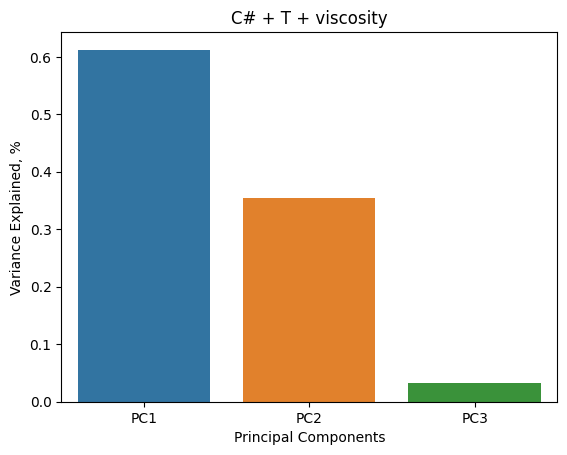

In [8]:
pca_analysis(density_features, 'C# + T + viscosity')

         PC1       PC2       PC3
0   0.090749  2.237050  0.081697
1   0.250184  2.185472  0.093630
2   1.015911  1.925971  0.122731
3   1.015911  1.925971  0.122731
4   1.793430  1.667074  0.163293
..       ...       ...       ...
71 -1.183273 -1.412812  0.111953
72 -0.897817 -1.517678  0.103345
73 -0.612360 -1.622545  0.094738
74 -0.326903 -1.727411  0.086130
75 -0.043412 -1.832377  0.075612

[76 rows x 3 columns]
[0.64648722 0.35176439 0.00174839]
0.9999999999999999


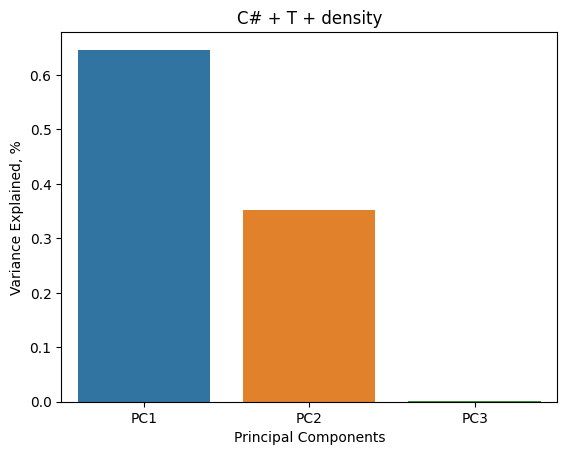

In [9]:
pca_analysis(viscosity_features, 'C# + T + density')

In [10]:
density_features.head(10)

,C#,T,viscosity
0,8,20.0,0.5420
1,8,25.0,0.5100
2,8,50.0,0.3870
3,8,50.0,0.3870
4,8,75.0,0.3040
5,8,75.0,0.3040
6,8,100.0,0.2450
7,9,20.0,0.7139
8,9,30.0,0.6170
9,9,40.0,0.5460


In [11]:
density.head(10)

0    703.00
1    698.60
2    678.20
3    678.20
4    657.20
5    657.20
6    635.30
7    717.63
8    710.20
9    702.50
Name: density, dtype: float64

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
    density_features, density, test_size=0.2, random_state=42)

In [13]:
lin_regr_dens = LinearRegression()
lin_regr_dens.fit(x_train, y_train)

LinearRegression()

In [14]:
y_pred = lin_regr_dens.predict(x_test)
calculate_metrics(y_test, y_pred)

Best metrics:
R²: 0.99469
RMSE: 3.20268


(0.9946851596652613, 3.2026757166375903)

In [15]:
data_for_dens.head(15)

,C#,T,viscosity,density
11,9,1.666667,0.942,NaN
12,9,4.444444,0.902,NaN
13,9,7.222222,0.865,NaN
14,9,10.000000,0.830,NaN
15,9,12.777778,0.797,NaN
16,9,15.555556,0.766,NaN
17,9,18.333333,0.737,NaN
18,9,21.111111,0.709,NaN
19,9,23.888889,0.683,NaN
20,9,26.666667,0.659,NaN


In [16]:
pred_dens = lin_regr_dens.predict(data_for_dens.iloc[:, :3])
predicted_dens_data = data_for_dens.iloc[:, :3]
predicted_dens_data['predicted density'] = pred_dens
predicted_dens_data

,C#,T,viscosity,predicted density
11,9,1.666667,0.942,731.408679
12,9,4.444444,0.902,729.409114
13,9,7.222222,0.865,727.392180
14,9,10.000000,0.830,725.363667
15,9,12.777778,0.797,723.323575
...,...,...,...,...
144,14,84.460000,0.807,719.577922
145,14,84.460000,0.806,719.583711
146,14,84.460000,0.807,719.577922
147,14,84.460000,0.804,719.595290


In [17]:
viscosity_features.head(10)

,C#,T,density
0,8,20.0,703.00
1,8,25.0,698.60
2,8,50.0,678.20
3,8,50.0,678.20
4,8,75.0,657.20
5,8,75.0,657.20
6,8,100.0,635.30
7,9,20.0,717.63
8,9,30.0,710.20
9,9,40.0,702.50


In [18]:
viscosity.head(10)

0    0.5420
1    0.5100
2    0.3870
3    0.3870
4    0.3040
5    0.3040
6    0.2450
7    0.7139
8    0.6170
9    0.5460
Name: viscosity, dtype: float64

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(
    viscosity_features, viscosity, test_size=0.25, random_state=35)

In [20]:
lin_regr_visc = LinearRegression()
lin_regr_visc.fit(X_train, Y_train)

LinearRegression()

In [21]:
Y_pred = lin_regr_visc.predict(X_test)
calculate_metrics(Y_test, Y_pred)

Best metrics:
R²: 0.86353
RMSE: 0.19060


(0.863529394983332, 0.19059597280597734)

In [22]:
kf = KFold(n_splits=4, random_state=35, shuffle=True)

In [23]:
gs = GridSearchCV(KNeighborsRegressor(), 
                  {'n_neighbors': np.arange(1, 5+1), 
                   'algorithm': ['ball_tree', 'kd_tree', 'brute']}, 
                  cv = kf, verbose=1, scoring='r2', n_jobs=-1)

In [24]:
gs.fit(X_train, Y_train)
best_knn = gs.best_estimator_
best_knn

Fitting 4 folds for each of 15 candidates, totalling 60 fits


KNeighborsRegressor(algorithm='ball_tree', n_neighbors=1)

In [25]:
Y_pred_knn = best_knn.predict(X_test)
r2_knn, rmse_knn = calculate_metrics(Y_test, Y_pred_knn)

Best metrics:
R²: 0.96241
RMSE: 0.10004


In [26]:
gs_forest = GridSearchCV(RandomForestRegressor(random_state=35), 
                      {'max_depth': [2, 10, 20, 50, 70], 
                      'n_estimators': [50, 100, 150, 200, 250], 
                      'max_features': ['sqrt', 'log2', None]},
                      cv = kf, verbose=1, scoring='r2', n_jobs=-1)

In [27]:
gs_forest.fit(X_train, Y_train)
best_forest = gs_forest.best_estimator_
best_forest

Fitting 4 folds for each of 75 candidates, totalling 300 fits


RandomForestRegressor(max_depth=10, max_features=None, random_state=35)

In [28]:
Y_pred_forest = best_forest.predict(X_test)
r2_forest, rmse_forest = calculate_metrics(Y_test, Y_pred_forest)

Best metrics:
R²: 0.99147
RMSE: 0.04765


In [29]:
data_for_visc.head(15)

,C#,T,viscosity,density
29,9,-17.777778,NaN,749.986170
30,9,-12.222222,NaN,745.340805
31,9,-6.666667,NaN,740.535255
32,9,-1.111111,NaN,735.889890
33,9,4.444444,NaN,731.084340
34,9,10.000000,NaN,726.438975
35,9,15.555556,NaN,721.633425
36,9,21.111111,NaN,716.988060
37,9,26.666667,NaN,712.342695
38,9,32.222222,NaN,707.537145


In [30]:
predicted_visc_data = data_for_visc.iloc[:, [0, 1, 3]]

In [31]:
pred_visc_lin = lin_regr_visc.predict(data_for_visc.iloc[:, [0, 1, 3]])
predicted_visc_data['predicted viscosity linear'] = pred_visc_lin

In [32]:
pred_visc_knn = best_knn.predict(data_for_visc.iloc[:, [0, 1, 3]])
predicted_visc_data['predicted viscosity knn'] = pred_visc_knn

In [33]:
pred_visc_forest = best_forest.predict(data_for_visc.iloc[:, [0, 1, 3]])
predicted_visc_data['predicted viscosity forest'] = pred_visc_forest
predicted_visc_data

,C#,T,density,predicted viscosity linear,predicted viscosity knn,predicted viscosity forest
29,9,-17.777778,749.986170,0.999498,1.4940,1.566760
30,9,-12.222222,745.340805,0.964104,1.4940,1.421950
31,9,-6.666667,740.535255,0.932632,1.4940,1.343285
32,9,-1.111111,735.889890,0.897239,0.9256,1.111667
33,9,4.444444,731.084340,0.865767,0.9256,0.948360
34,9,10.000000,726.438975,0.830373,0.9256,0.869262
35,9,15.555556,721.633425,0.798901,0.9256,0.828430
36,9,21.111111,716.988060,0.763507,0.8490,0.759602
37,9,26.666667,712.342695,0.728114,0.5420,0.746580
38,9,32.222222,707.537145,0.696642,0.5460,0.624620


In [34]:
vd_ind = train_data.index
dens_na_ind = data_for_dens.index
visc_na_ind = data_for_visc.index
vd_dens_na = np.concatenate((vd_ind, dens_na_ind))
vd_visc_na = np.concatenate((vd_ind, visc_na_ind))
new_data = df
new_data['predicted viscosity'] = np.nan
new_data['predicted density'] = np.nan
new_data.iloc[vd_dens_na, 5] = lin_regr_dens.predict(new_data.iloc[vd_dens_na, :3])
new_data.iloc[vd_visc_na, 4] = best_forest.predict(new_data.iloc[vd_visc_na, [0, 1, 3]])
new_data

,C#,T,viscosity,density,predicted viscosity,predicted density
0,8,20.0,0.542,703.0,0.549350,708.221262
1,8,25.0,0.510,698.6,0.525200,704.390464
2,8,50.0,0.387,678.2,0.398639,685.022263
3,8,50.0,0.387,678.2,0.398639,685.022263
4,8,75.0,0.304,657.2,0.306266,665.422480
...,...,...,...,...,...,...
163,15,60.0,1.346,740.4,1.297180,746.881612
164,15,70.0,1.162,733.3,1.117515,739.914757
165,15,80.0,1.013,726.2,0.956790,732.745270
166,15,90.0,0.892,719.1,0.854508,725.413676


In [35]:
nonane = df[df['C#'] == 9]
nonane = nonane.sort_values(by=['T', 'viscosity'])
nonane.head(20)

,C#,T,viscosity,density,predicted viscosity,predicted density
29,9,-17.777778,NaN,749.986170,1.566760,NaN
30,9,-12.222222,NaN,745.340805,1.421950,NaN
31,9,-6.666667,NaN,740.535255,1.343285,NaN
32,9,-1.111111,NaN,735.889890,1.111667,NaN
11,9,1.666667,0.9420,NaN,NaN,731.408679
12,9,4.444444,0.9020,NaN,NaN,729.409114
33,9,4.444444,NaN,731.084340,0.948360,NaN
13,9,7.222222,0.8650,NaN,NaN,727.392180
14,9,10.000000,0.8300,NaN,NaN,725.363667
34,9,10.000000,NaN,726.438975,0.869262,NaN


In [36]:
nonane_data = nonane.drop(index=vd_ind, errors='ignore')
nonane_data = nonane_data.reset_index(drop=True)
nonane_data.head(20)

,C#,T,viscosity,density,predicted viscosity,predicted density
0,9,-17.777778,NaN,749.986170,1.566760,NaN
1,9,-12.222222,NaN,745.340805,1.421950,NaN
2,9,-6.666667,NaN,740.535255,1.343285,NaN
3,9,-1.111111,NaN,735.889890,1.111667,NaN
4,9,1.666667,0.942,NaN,NaN,731.408679
5,9,4.444444,0.902,NaN,NaN,729.409114
6,9,4.444444,NaN,731.084340,0.948360,NaN
7,9,7.222222,0.865,NaN,NaN,727.392180
8,9,10.000000,0.830,NaN,NaN,725.363667
9,9,10.000000,NaN,726.438975,0.869262,NaN


In [37]:
tetradecane = df[df['C#'] == 14]
tetradecane = tetradecane.sort_values(by=['T', 'viscosity'])
tetradecane.head(20)

,C#,T,viscosity,density,predicted viscosity,predicted density
103,14,9.98,2.881,NaN,NaN,767.393743
104,14,9.98,2.888,NaN,NaN,767.353216
102,14,9.98,2.891,NaN,NaN,767.335847
149,14,10.00,NaN,770.0,2.52532,NaN
106,14,12.17,2.727,NaN,NaN,766.526292
109,14,12.17,2.729,NaN,NaN,766.514713
105,14,12.17,2.731,NaN,NaN,766.503134
107,14,12.17,2.735,NaN,NaN,766.479976
108,14,12.17,2.735,NaN,NaN,766.479976
112,14,14.65,2.570,NaN,NaN,765.443278


In [38]:
tetradecane_data = tetradecane.drop(index=vd_ind, errors='ignore')
tetradecane_data = tetradecane_data.reset_index(drop=True)
tetradecane_data.head(20)

,C#,T,viscosity,density,predicted viscosity,predicted density
0,14,9.98,2.881,NaN,NaN,767.393743
1,14,9.98,2.888,NaN,NaN,767.353216
2,14,9.98,2.891,NaN,NaN,767.335847
3,14,10.00,NaN,770.0,2.52532,NaN
4,14,12.17,2.727,NaN,NaN,766.526292
5,14,12.17,2.729,NaN,NaN,766.514713
6,14,12.17,2.731,NaN,NaN,766.503134
7,14,12.17,2.735,NaN,NaN,766.479976
8,14,12.17,2.735,NaN,NaN,766.479976
9,14,14.65,2.570,NaN,NaN,765.443278


In [39]:
def plots(data, name_title):
    X = data["T"]
    
    y_true_density = data["density"]
    y_predict_density = data["predicted density"]

    plt.title(name_title)
    plt.plot(X, y_true_density, '^', label="existing density")
    plt.plot(X, y_predict_density, 'o', label="predicted density")
    plt.legend()
    plt.grid()
    plt.xlabel("T, °С")
    plt.ylabel("Density, kg/m^3")
    plt.savefig('Density of '+ name_title, dpi = 200)
    plt.show()
    
    y_true_viscosity = data["viscosity"]
    y_predict_viscosity = data["predicted viscosity"]
    
    plt.title(name_title)
    plt.plot(X, y_true_viscosity, '^', label="existing viscosity")
    plt.plot(X, y_predict_viscosity, 'o', label="predicted viscosity")
    plt.legend()
    plt.grid()
    plt.xlabel("T, °С")
    plt.ylabel("Viscosity, mPa*s")
    plt.savefig('Viscosity of '+ name_title, dpi = 200)
    plt.show()

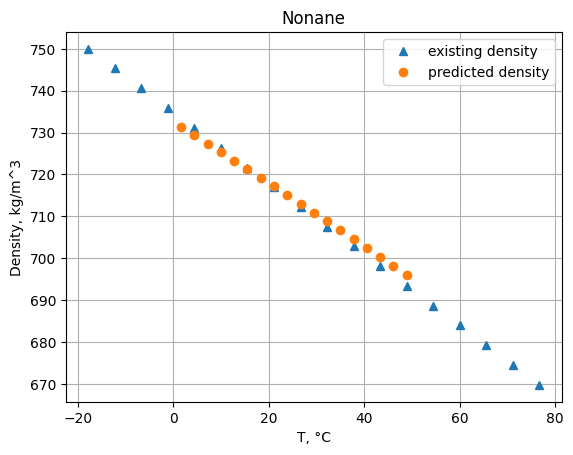

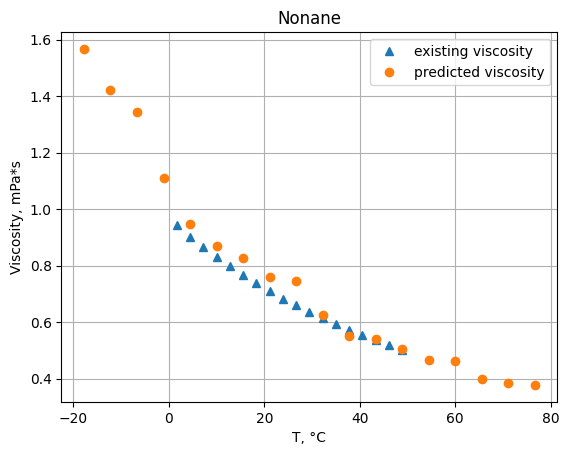

In [40]:
plots(nonane_data, name_title = "Nonane")

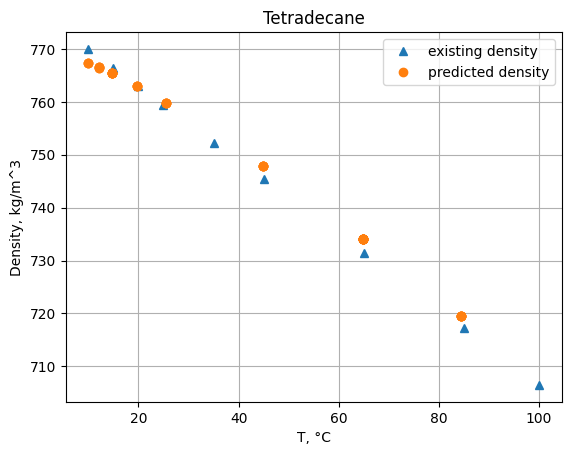

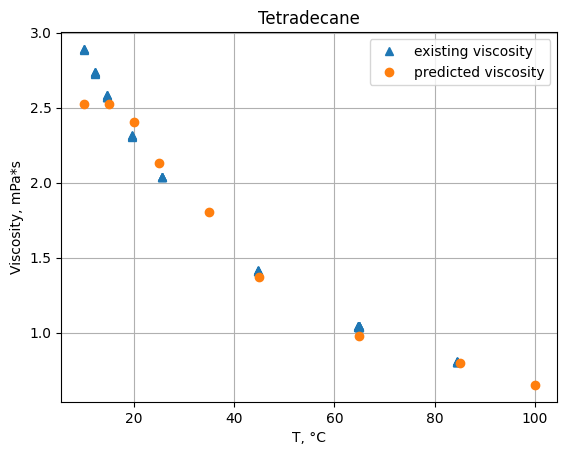

In [41]:
plots(tetradecane_data, name_title = "Tetradecane")